## TUTORIAL 02 - Elastic block problem
**_Keywords: POD-Galerkin method, vector problem_**

### 1. Introduction
In this Tutorial we consider a linear elasticity problem in a two-dimensional square domain $\Omega$.

The domain is partioned in nine square subdomains.

Parameters of this problem include Young moduli of each subdomain, as well as lateral traction on the right side of square. In particular:
* the ratio between the Young modulus of the each subdomain $\Omega_{p+1}$, $p=0,\dots,7$ and the top-right subdomain $\Omega_9$ is denoted by $\mu_p$, being

$$
\mu_p \in \left[1, 100\right] \qquad \text{for }p=0,\dots,7.
$$

* the horizontal tractions on each boundary $\Gamma_{p-6}$, $p=8,\dots,10$, being

$$
\mu_p \in \left[-1,1\right] \qquad \text{for } p=8,\dots, 10.
$$

For what concerns the remaining boundaries, the left boundary $\Gamma_6$ is clamped, while the top and bottom boundaries $\Gamma_1 \cup \Gamma_5$ are traction free.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0, \cdots,\mu_{10})
$$
on the parameter domain
$$
\mathbb{P}=[1,100]^8\times[-1,1]^3.
$$

In order to obtain a faster approximation of the problem we pursue a model reduction by means of a POD-Galerkin reduced order method.

### 2. Parametrized formulation

Let $\boldsymbol{u}(\boldsymbol{\mu})$ be the displacement in the domain $\Omega$.

In each subdomain $\Omega_{p+1}$, $p=0,\dots,7$, we assume an isotropic linear elastic material, characterized by the following Lamè constants for plane strain
$$\lambda_1(\mu_p) = \frac{\mu_p \nu}{(1+\nu)(1-2\nu)},$$
$$\lambda_2(\mu_p) = \frac{\mu_p}{2(1+\nu)},$$
for $\nu=0.30$, with the following Piola-Kirchhoff tensor

$$
\boldsymbol{\pi}(\boldsymbol{u}; \mu_p) = 
\lambda_1(\mu_p)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\; \boldsymbol{I} +
2\;\lambda_2(\mu_p)\;\nabla_{S}\boldsymbol{u}
$$
where $\nabla_{S}$ denotes the symmetric part of the gradient.

Similarly, the Piola-Kirchhoff tensor in the top right subdomain $\Omega_9$ is given by $\boldsymbol{\pi}(\boldsymbol{u}; 1)$.

Thus, the Piola-Kirchhoff tensor on the domain $\Omega$ can be obtained as
$$
\boldsymbol{P}(\boldsymbol{u}; \boldsymbol{\mu}) = 
\Lambda_1(\boldsymbol{\mu})\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\; \boldsymbol{I} +
2\;\Lambda_2(\boldsymbol{\mu})\;\nabla_{S}\boldsymbol{u}
$$
where
$$
\Lambda_1(\boldsymbol{\mu}) = \sum_{p=0}^{7} \lambda_1(\mu_p) \mathbb{1}_{\Omega_{p+1}} + \lambda_1(1) \mathbb{1}_{\Omega_{9}}
$$
$$
\Lambda_2(\boldsymbol{\mu}) = \sum_{p=0}^{7} \lambda_2(\mu_p) \mathbb{1}_{\Omega_{p+1}} + \lambda_2(1) \mathbb{1}_{\Omega_{9}}
$$

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $\boldsymbol{u}(\boldsymbol{\mu})$ such that
$$
\begin{cases}
	- \text{div} \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) = 0 & \text{in } \Omega,\\
    \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mathbf{0} & \text{on } \Gamma_{1},\\
	\boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mu_p \mathbf{n} & \text{on } \Gamma_{p-6}, p=8,\dots, 10,\\
    \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mathbf{0} & \text{on } \Gamma_{5},\\
	\boldsymbol{u}(\boldsymbol{\mu}) = \boldsymbol{0} & \text{on } \Gamma_{6},\\
\end{cases}
$$
<br>

where $\mathbf{n}$ denotes the outer normal to the boundary $\partial\Omega$.

The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{\boldsymbol{v}\in H^1(\Omega; \mathbb{R}^2) : \boldsymbol{v}|_{\Gamma_{6}}=\boldsymbol{0}\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(\boldsymbol{u}, \boldsymbol{v}; \boldsymbol{\mu})=\int_{\Omega}
\left\{
\Lambda_1(\boldsymbol{\mu})\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\Lambda_2(\boldsymbol{\mu})\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v}
\right\}  d\boldsymbol{x}
$$,
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(\boldsymbol{v}; \boldsymbol{\mu})= \sum_{p=8}^{10} \mu_p \int_{\Gamma_{p-6}} \boldsymbol{v} \cdot \mathbf{n} \ ds$$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward. Indeed, owing to the definitions of $\Lambda_1(\boldsymbol{\mu})$ and $\Lambda_2(\boldsymbol{\mu})$, we have:
$$
a(\boldsymbol{u}, \boldsymbol{v}; \boldsymbol{\mu}) = \sum_{p=0}^7 \underbrace{\mu_{\color{red} p}}_{\Theta^{a}_{\color{red} p}(\boldsymbol{\mu})} \underbrace{\int_{\Omega_{\color{red}{p + 1}}}
\left\{\lambda_1(1)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\lambda_2(1)\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v} \right\}  d\boldsymbol{x}}_{a_{\color{red} p}(\boldsymbol{u}, \boldsymbol{v})} +\\
\underbrace{1}_{\Theta^{a}_{\color{red} 8}(\boldsymbol{\mu})} \underbrace{\int_{\Omega_{\color{red} 9}}
\left\{\lambda_1(1)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\lambda_2(1)\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v} \right\}  d\boldsymbol{x}}_{a_{\color{red} 8}(\boldsymbol{u}, \boldsymbol{v})}\\
$$
$$
f(\boldsymbol{v}; \boldsymbol{\mu}) = 
\sum_{p=8}^{10} \underbrace{\mu_{\color{red} p}}_{\Theta^{f}_{\color{red}{p-8}}(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{\color{red}{p-6}}} \boldsymbol{v} \cdot \mathbf{n}}_{f_{\color{red}{p-8}}(\boldsymbol{v})}.
$$

We will implement the numerical discretization of the problem in the class
```
class ElasticBlock(EllipticCoerciveProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(\boldsymbol{u}, \boldsymbol{v})$ and linear forms $f_*(\boldsymbol{v})$ in
```
    def assemble_operator(self, term):
```

In [2]:
class ElasticBlock(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # ...
        self.f = Constant((1.0, 0.0))
        self.E = 1.0
        self.nu = 0.3
        self.lambda_1 = self.E * self.nu / ((1.0 + self.nu) * (1.0 - 2.0 * self.nu))
        self.lambda_2 = self.E / (2.0 * (1.0 + self.nu))

    # Return custom problem name
    def name(self):
        return "ElasticBlock"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = mu[1]
            theta_a2 = mu[2]
            theta_a3 = mu[3]
            theta_a4 = mu[4]
            theta_a5 = mu[5]
            theta_a6 = mu[6]
            theta_a7 = mu[7]
            theta_a8 = 1.
            return (theta_a0, theta_a1, theta_a2, theta_a3, theta_a4, theta_a5, theta_a6, theta_a7, theta_a8)
        elif term == "f":
            theta_f0 = mu[8]
            theta_f1 = mu[9]
            theta_f2 = mu[10]
            return (theta_f0, theta_f1, theta_f2)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = self.elasticity(u, v) * dx(1)
            a1 = self.elasticity(u, v) * dx(2)
            a2 = self.elasticity(u, v) * dx(3)
            a3 = self.elasticity(u, v) * dx(4)
            a4 = self.elasticity(u, v) * dx(5)
            a5 = self.elasticity(u, v) * dx(6)
            a6 = self.elasticity(u, v) * dx(7)
            a7 = self.elasticity(u, v) * dx(8)
            a8 = self.elasticity(u, v) * dx(9)
            return (a0, a1, a2, a3, a4, a5, a6, a7, a8)
        elif term == "f":
            ds = self.ds
            f = self.f
            f0 = inner(f, v) * ds(2)
            f1 = inner(f, v) * ds(3)
            f2 = inner(f, v) * ds(4)
            return (f0, f1, f2)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant((0.0, 0.0)), self.boundaries, 6)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(u, v) * dx + inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

    # Auxiliary function to compute the elasticity bilinear form
    def elasticity(self, u, v):
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        return 2.0 * lambda_2 * inner(sym(grad(u)), sym(grad(v))) + lambda_1 * tr(sym(grad(u))) * tr(sym(grad(v)))

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/elastic_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/elastic_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/elastic_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = VectorFunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the ElasticBlock class

In [5]:
problem = ElasticBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (-1.0, 1.0),
    (-1.0, 1.0),
    (-1.0, 1.0)
]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(2e-4)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()

#### 4.5.3 Train PDNN

In [8]:
input_normalization_pdnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.MinMaxNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
#pdnn_loss = Losses.Weighted_PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

pdnn_net.VERBOSE = False

Initial training...
0 0.14564187643882015 	Loss(validation) = 0.1129355873628375
100 0.05816605390325315 	Loss(validation) = 0.057895235131831306
200 0.052749102223942676 	Loss(validation) = 0.06047282355850822
300 0.03643382417591109 	Loss(validation) = 0.060643908557214715
400 0.01892252038356804 	Loss(validation) = 0.06520638063208344
500 0.009513670904810487 	Loss(validation) = 0.07462653819321269
600 0.0051548519818085245 	Loss(validation) = 0.08361936177140825
700 0.0028636184035264987 	Loss(validation) = 0.08882909116155864
800 0.001665260158859556 	Loss(validation) = 0.09128890103069107
900 0.0010376117002592884 	Loss(validation) = 0.09328359725626328
1000 0.0006697175994278369 	Loss(validation) = 0.09528802089653578
1100 0.00044109389999529003 	Loss(validation) = 0.09724348663894848
1200 0.0002971945557468459 	Loss(validation) = 0.09901634663189693
1300 0.00020562920381149487 	Loss(validation) = 0.10049398356494663
1400 0.00014612521096457276 	Loss(validation) = 0.101650612348

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemen

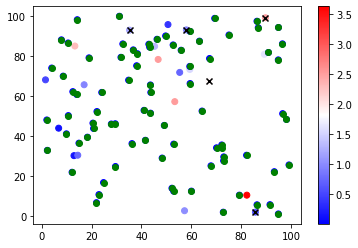

10000 0.00032528576191889904 	Loss(validation) = 0.076596390055413
10100 0.00011228562660380671 	Loss(validation) = 0.07838214912576257
10200 5.05556846998846e-05 	Loss(validation) = 0.07935227835158752
10300 2.5279242110921477e-05 	Loss(validation) = 0.07994249499553348
10400 1.3466413053079939e-05 	Loss(validation) = 0.0803003873770942
10500 7.434860977606196e-06 	Loss(validation) = 0.08052340128585876
10600 4.190048629598161e-06 	Loss(validation) = 0.08066903059096757
10700 2.436337553767292e-06 	Loss(validation) = 0.0807645737054433
10800 1.5322140965334368e-06 	Loss(validation) = 0.08081283208315326
10900 1.1016080525538466e-06 	Loss(validation) = 0.08089877705514678
11000 2.940188007906795e-06 	Loss(validation) = 0.0809710380055133
11100 2.7122404928397213e-06 	Loss(validation) = 0.08093929251859858
11200 3.350654222482925e-07 	Loss(validation) = 0.08092380111751801
11300 3.1607535273066484e-07 	Loss(validation) = 0.08095724589709426
11400 2.0511142488608002e-07 	Loss(validation)

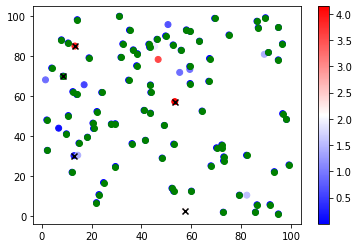

20000 0.0005525607427429145 	Loss(validation) = 0.050819975300072824
20100 0.00030098084819509446 	Loss(validation) = 0.05181404651345723
20200 0.00023719550404524765 	Loss(validation) = 0.05259247287972742
20300 0.00021307807480265822 	Loss(validation) = 0.05312930925771356
20400 0.00020183541789672437 	Loss(validation) = 0.05349087210350693
20500 0.00019589340178842685 	Loss(validation) = 0.053732930541469756
20600 0.00019250827266860632 	Loss(validation) = 0.05389422678662501
20700 0.0001904799180143585 	Loss(validation) = 0.05400106778751236
20800 0.0001892156905647304 	Loss(validation) = 0.05407143787958703
20900 0.00018867949451721304 	Loss(validation) = 0.05411397662128243
21000 0.00018788375029101727 	Loss(validation) = 0.05414555812985226
21100 0.00018753707403575332 	Loss(validation) = 0.054162759133401
21200 0.00018734382847866767 	Loss(validation) = 0.054182429271661905
21300 0.00019007343730428216 	Loss(validation) = 0.0542224149908922
21400 0.0001870153056261259 	Loss(val

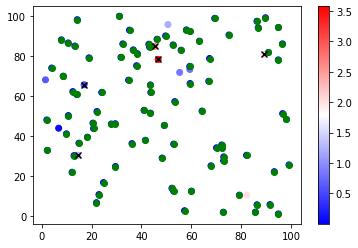

30000 0.0004936695722638512 	Loss(validation) = 0.0310662799145353
30100 0.0003180024372129385 	Loss(validation) = 0.031009997787120974
30200 0.00025869563014032065 	Loss(validation) = 0.030877413599916935
30300 0.00022964008983900863 	Loss(validation) = 0.030788571306038
30400 0.00021264881275848168 	Loss(validation) = 0.030758692305569307
30500 0.0002017584349599316 	Loss(validation) = 0.030776034546611757
30600 0.00019470354892202715 	Loss(validation) = 0.030825322545454167
30700 0.0001894342126156218 	Loss(validation) = 0.030903978146707978
30800 0.00018652295227453578 	Loss(validation) = 0.03097237091797599
30900 0.0001834033464807068 	Loss(validation) = 0.031087535055584554
31000 0.00018223428137851156 	Loss(validation) = 0.031185962146082002
31100 0.00018031782870983002 	Loss(validation) = 0.03127175779859661
31200 0.00017940287771018467 	Loss(validation) = 0.03135672676556726
31300 0.00018384580156736446 	Loss(validation) = 0.03139671606972813
31400 0.00017823240951795726 	Loss

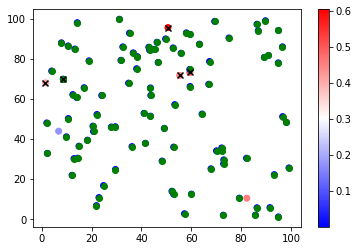

40000 0.00048173646781309184 	Loss(validation) = 0.01423845432607178
40100 0.0003407097462640818 	Loss(validation) = 0.014094343769805437
40200 0.00029006590424884447 	Loss(validation) = 0.014144082693286509
40300 0.0002655711770085 	Loss(validation) = 0.014278509136066006
40400 0.0002517544765440666 	Loss(validation) = 0.014440105337670203
40500 0.00024319946839524692 	Loss(validation) = 0.014595432322868926
40600 0.00023758833746036432 	Loss(validation) = 0.014730046144937678
40700 0.00023383421754974337 	Loss(validation) = 0.014839177123024145
40800 0.00023121006206369807 	Loss(validation) = 0.014925422281611424
40900 0.000229367946113678 	Loss(validation) = 0.014992461173828141
41000 0.00022805036811787599 	Loss(validation) = 0.015042404642504201
41100 0.00022710282730973132 	Loss(validation) = 0.015082554775720153
41200 0.0002275241749121262 	Loss(validation) = 0.015110027622639358
41300 0.00022592227114510047 	Loss(validation) = 0.01514109947517745
41400 0.000225470221422178 	Los

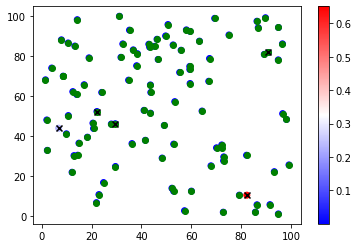

50000 0.0004978594396181815 	Loss(validation) = 0.003470538340301598
50100 0.00044631570148774525 	Loss(validation) = 0.0033567077307206524
50200 0.0004301865504544897 	Loss(validation) = 0.0033203127004495245
50300 0.0004228305277672837 	Loss(validation) = 0.0033036091116679833
50400 0.00041882987566163116 	Loss(validation) = 0.0032951718034710956
50500 0.00041647536380054793 	Loss(validation) = 0.003291065379164603
50600 0.0004149875573284164 	Loss(validation) = 0.0032887407074211365
50700 0.0004140211882482893 	Loss(validation) = 0.0032859945800256746
50800 0.00041354947523329513 	Loss(validation) = 0.0032918498093787002
50900 0.0004128092738574376 	Loss(validation) = 0.003286402887645809
51000 0.00041244721351735666 	Loss(validation) = 0.0032861916877954594
51100 0.0004129104602861624 	Loss(validation) = 0.0032819833419166678
51200 0.00041230424087036966 	Loss(validation) = 0.0032813878168752404
51300 0.00041225813334683133 	Loss(validation) = 0.003282214370063039
51400 0.000411790

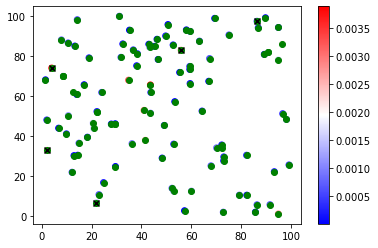

60000 0.0006285451022708962 	Loss(validation) = 0.0033078839182193545
60100 0.0006262590912485168 	Loss(validation) = 0.0033013945234971706
60200 0.000625525560214321 	Loss(validation) = 0.0032981520052240676
60300 0.0006251883298986836 	Loss(validation) = 0.00329595435152854
60400 0.0006251014931991026 	Loss(validation) = 0.0032937828915329675
60500 0.000624927304984857 	Loss(validation) = 0.0032915430215844795
60600 0.0006249514804778833 	Loss(validation) = 0.003292836120834635
60700 0.0006248040364124506 	Loss(validation) = 0.003293724690262499
60800 0.0006253046966650405 	Loss(validation) = 0.003291415214399554
60900 0.0006248821121478077 	Loss(validation) = 0.0032916732506310703
61000 0.000624794234316765 	Loss(validation) = 0.003287515134079407
61100 0.0006253617668746037 	Loss(validation) = 0.003295568127187321
61200 0.0006249062056082719 	Loss(validation) = 0.003286001486540332
61300 0.0006265447999150418 	Loss(validation) = 0.0032883778854574525
61400 0.0006247441195760678 	Lo

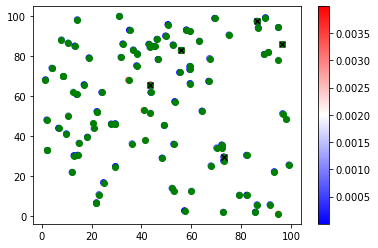

70000 0.0006768517548506138 	Loss(validation) = 0.003297642829600222
70100 0.000676301819636018 	Loss(validation) = 0.003295550692265569
70200 0.0006761297217577934 	Loss(validation) = 0.003293907536841746
70300 0.0006760723049619089 	Loss(validation) = 0.003292118646043232
70400 0.0006764533286293031 	Loss(validation) = 0.003290396443671476
70500 0.0006764768891319058 	Loss(validation) = 0.0032843443384128895
70600 0.0006760014342963201 	Loss(validation) = 0.003292031136558509
70700 0.0006760970100406592 	Loss(validation) = 0.0032898828826881913
70800 0.0006766070572283463 	Loss(validation) = 0.003300410252580239
70900 0.000676125230386365 	Loss(validation) = 0.00328989867462694
71000 0.0006765293152971388 	Loss(validation) = 0.003291402283224502
71100 0.000675967894157195 	Loss(validation) = 0.003291941046865532
71200 0.0006765946100060209 	Loss(validation) = 0.0032916789208184477
71300 0.0006763492696721815 	Loss(validation) = 0.0032825159269108286
71400 0.0006760174393595544 	Loss(

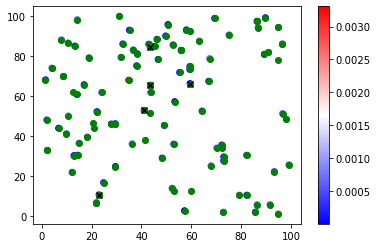

80000 0.0007134612438963371 	Loss(validation) = 0.0032993205026856432
80100 0.0007130321182031203 	Loss(validation) = 0.0032961906468683146
80200 0.0007128952170867683 	Loss(validation) = 0.0032945847300975997
80300 0.000712838799873732 	Loss(validation) = 0.003293016844941148
80400 0.0007130993659586884 	Loss(validation) = 0.0032952148943929454
80500 0.0007127979258266787 	Loss(validation) = 0.0032932021639300118
80600 0.0007128006670782044 	Loss(validation) = 0.0032941962036090885
80700 0.0007138238451700738 	Loss(validation) = 0.00330675656248287
80800 0.0007127858491860846 	Loss(validation) = 0.0032931509133149357
80900 0.0007127667303211691 	Loss(validation) = 0.0032921197561397984
81000 0.0007127952131066544 	Loss(validation) = 0.0032932458900390062
81100 0.0007127683751592194 	Loss(validation) = 0.0032917199119668677
81200 0.0007129963273341684 	Loss(validation) = 0.0032883818626809197
81300 0.000712821804287642 	Loss(validation) = 0.0032931612498409207
81400 0.00071286426819476

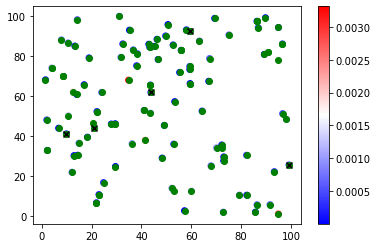

90000 0.0008373250853026269 	Loss(validation) = 0.003285777087120115
90100 0.0008353636959375412 	Loss(validation) = 0.0032903170182747173
90200 0.0008347191445396542 	Loss(validation) = 0.0032915764952995276
90300 0.0008347503878021526 	Loss(validation) = 0.0033021291598634276
90400 0.0008342787535350048 	Loss(validation) = 0.0032923337614098086
90500 0.0008349672339637663 	Loss(validation) = 0.0032903089828164025
90600 0.0008341924454915386 	Loss(validation) = 0.0032926145006435437
90700 0.0008341900347698976 	Loss(validation) = 0.003288950171326281
90800 0.0008340880110761785 	Loss(validation) = 0.003291246200997215
90900 0.0008340552391693148 	Loss(validation) = 0.003291430214485637
91000 0.0008341867335143134 	Loss(validation) = 0.003286765567964627
91100 0.0008341067666828957 	Loss(validation) = 0.0032911399445411547
91200 0.000834288393409665 	Loss(validation) = 0.0032870760438113806
91300 0.0008340777478910183 	Loss(validation) = 0.0032908797238793376
91400 0.000834050252216806

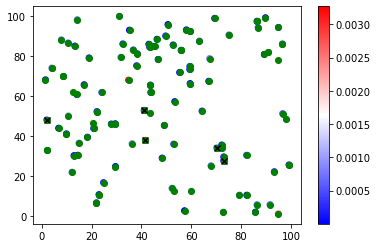

100000 0.0008629756144811731 	Loss(validation) = 0.0032933403496094604
100100 0.0008625407728447969 	Loss(validation) = 0.00329240712038136
100200 0.0008624106821268857 	Loss(validation) = 0.003293879223081082
100300 0.0008623300987827899 	Loss(validation) = 0.0032906148717151903
100400 0.0008622820732082476 	Loss(validation) = 0.0032924012545677925
100500 0.0008622644414001124 	Loss(validation) = 0.0032920468705294453
100600 0.0008623130385204134 	Loss(validation) = 0.0032905996908114774
100700 0.0008622474292430262 	Loss(validation) = 0.0032925694093977943
100800 0.000862397866388764 	Loss(validation) = 0.003295185195372322
100900 0.0008622281959011715 	Loss(validation) = 0.0032914444950629456
101000 0.0008622322405752237 	Loss(validation) = 0.0032928661466505786
101100 0.0008623907331789454 	Loss(validation) = 0.0032900198979153032
101200 0.0008623649433851399 	Loss(validation) = 0.0032928101034907014
101300 0.0008622493884015922 	Loss(validation) = 0.003291825759825553
101400 0.000

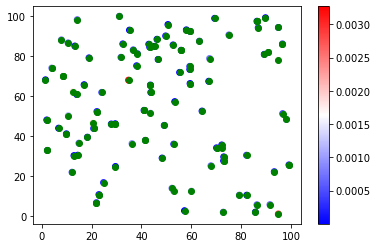

In [9]:
import matplotlib.pyplot as plt
n = 100 # number of parameters for which we compute residuals each iteration
num_new_params = 5 # number of parameters with which we augment data each iteration
assert num_new_params <= n

# train PDNN
print("Initial training...")
pdnn_trainer.train()

new_parameters = pdnn_net.augment_parameters_with_time(
        RONNData.get_new_parameters(pdnn_net, n)
)

print("Assembling residuals...")
residuals, _, loss_functions = ErrorAnalysis.get_residuals(
    pdnn_net, data, new_parameters, 
    input_normalization_pdnn, output_normalization_pdnn,
    plot_residuals=True
)


print("Beginning data augmentation cycles...")
for i in range(10):
    #sort_indices = np.argsort(-residuals)
    #high_residual_params = new_parameters[sort_indices[:num_new_params]]
    #print(high_residual_params)
    
    
    probabilities = residuals
    probabilities /= np.sum(probabilities)
    sample_indices = np.random.choice(residuals.shape[0], size=residuals.shape[0],
                                      replace=False, p=probabilities)
    cumulative_probs = np.cumsum(probabilities[sample_indices])
    last_index = np.searchsorted(cumulative_probs, 0.25) + 1
    sample_indices = sample_indices[:num_new_params]#sample_indices[:last_index]
    high_residual_params = new_parameters[sample_indices]
    plt.scatter(high_residual_params[:, 0].numpy().reshape(-1), 
                high_residual_params[:, 1].numpy().reshape(-1), marker='x', color='black')
    
    plt.show()
    
    # solve reduced PDE system for parameters found above and augment training data
    for j, mu in enumerate(high_residual_params):
        reduced_problem.set_mu(tuple(np.array(mu)))
        reduced_problem.solve()
        solution = torch.tensor(np.array(reduced_problem._solution.vector()[:])).view(-1, 1)
        pdnn_loss.concatenate_snapshots(solution)
        
    data.train_data = torch.cat([data.train_data, high_residual_params])
    
    # train PDNN
    pdnn_trainer.train()
    
    residuals, _, _ = ErrorAnalysis.get_residuals(
        pdnn_net, data, new_parameters, 
        input_normalization_pdnn, output_normalization_pdnn,
        loss_functions, plot_residuals=True
    )

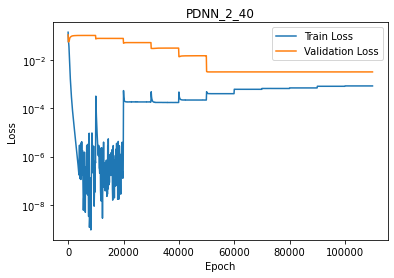

In [10]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

In [11]:
input_normalization_prnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_prnn = Normalization.MinMaxNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=225)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=110000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [12]:
prnn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
0 2.020305248735233 	Loss(validation) = 1.5891837888453246
100 0.11808758323105865 	Loss(validation) = 0.10248111629854752
200 0.095041545179434 	Loss(validation) = 0.0818400991825656
300 0.08903571742857629 	Loss(validation) = 0.07839751755390688
400 0.08753562472234032 	Loss(validation) = 0.07865813424797981
500 0.08649699031704514 	Loss(validation) = 0.07872475731965617
600 0.08556371342240576 	Loss(validation) = 0.07849927464277963
700 0.08463733557806727 	Loss(validation) = 0.07807904425142326
800 0.08365353357055855 	Loss(validation) = 0.07752215631868721
900 0.08256161291151451 	Loss(validation) = 0.0768546765533371
1000 0.08131419468956505 	Loss(validation) = 0.0760845980129731
1100 0.07985357887578712 	Loss(validation) = 0.07521500148463588
1200 0.07809684016327409 	Loss(validation) = 0.07425237666899989
1300 0.07592903966158153 	Loss(validation) = 

12400 0.008807715002725975 	Loss(validation) = 0.3356723878022542
12500 0.008764607275565137 	Loss(validation) = 0.33665883972991784
12600 0.008720723585128966 	Loss(validation) = 0.3381433713613365
12700 0.008716141315208913 	Loss(validation) = 0.3385133702199703
12800 0.008588256723541878 	Loss(validation) = 0.3396670674404785
12900 0.00853770243551045 	Loss(validation) = 0.3406866327630768
13000 0.008554433756456089 	Loss(validation) = 0.3415096127268404
13100 0.008433705810284454 	Loss(validation) = 0.34270589675283103
13200 0.008395688051273973 	Loss(validation) = 0.3436462655629158
13300 0.009554503208242165 	Loss(validation) = 0.34636893898919235
13400 0.008286984936098106 	Loss(validation) = 0.3458152566598472
13500 0.00824382416093181 	Loss(validation) = 0.3469499933355229
13600 0.008290925439491278 	Loss(validation) = 0.3477352152077465
13700 0.00814843236080548 	Loss(validation) = 0.3489850586316985
13800 0.008112022985139111 	Loss(validation) = 0.34997025727643294
13900 0.0

24800 0.005534502636632174 	Loss(validation) = 0.4483710487068781
24900 0.006043770016798973 	Loss(validation) = 0.44999819255461637
25000 0.005463557205914887 	Loss(validation) = 0.45140190753826925
25100 0.005454089977959073 	Loss(validation) = 0.4511798921532809
25200 0.005467437822981551 	Loss(validation) = 0.4521256308917474
25300 0.0054190988385771945 	Loss(validation) = 0.4524571524713945
25400 0.005405493335012518 	Loss(validation) = 0.45323691831818497
25500 0.005920148133833422 	Loss(validation) = 0.45198123798833834
25600 0.005638873077341176 	Loss(validation) = 0.45688828273031556
25700 0.005386338257663982 	Loss(validation) = 0.4549317842887435
25800 0.005440647985799103 	Loss(validation) = 0.4570542226758584
25900 0.0055096213356313215 	Loss(validation) = 0.4579161067667457
26000 0.005335722337642125 	Loss(validation) = 0.45676244677835265
26100 0.005604050694984634 	Loss(validation) = 0.45538636487106554
26200 0.005428826303629664 	Loss(validation) = 0.45985327892700323


37200 0.004560741223423573 	Loss(validation) = 0.5067973808434882
37300 0.004950211765242914 	Loss(validation) = 0.5048875056037789
37400 0.0044199690378466435 	Loss(validation) = 0.50687278098188
37500 0.004414490474740526 	Loss(validation) = 0.507235923495495
37600 0.00441080936276117 	Loss(validation) = 0.5073888041412258
37700 0.004556986346051593 	Loss(validation) = 0.5073739536974254
37800 0.004397473205395849 	Loss(validation) = 0.5080792982366286
37900 0.004399302346217826 	Loss(validation) = 0.5084368756714951
38000 0.004386514803303137 	Loss(validation) = 0.5086657983172549
38100 0.004383413018947438 	Loss(validation) = 0.5089301348082695
38200 0.004375677149816139 	Loss(validation) = 0.5092356640036211
38300 0.004370551210632775 	Loss(validation) = 0.5095078980860732
38400 0.004615592742843521 	Loss(validation) = 0.5063241077461473
38500 0.00435954849272876 	Loss(validation) = 0.5101427976835321
38600 0.004354962576406798 	Loss(validation) = 0.5103863840321622
38700 0.004353

49700 0.003871426724411464 	Loss(validation) = 0.538232891895606
49800 0.0038663012355038464 	Loss(validation) = 0.5384264907937458
49900 0.0038632699423245933 	Loss(validation) = 0.5387391063156091
50000 0.0038845609710328076 	Loss(validation) = 0.5396054175507016
50100 0.003855599650833498 	Loss(validation) = 0.5390879888456689
50200 0.0038727982841969466 	Loss(validation) = 0.540279469454779
50300 0.003959954495915532 	Loss(validation) = 0.5395562102803093
50400 0.003845040770258523 	Loss(validation) = 0.5398171558546501
50500 0.003919687236115559 	Loss(validation) = 0.5384564479910806
50600 0.003976480707302453 	Loss(validation) = 0.5400894461646981
50700 0.003834540302571028 	Loss(validation) = 0.5405878607145156
50800 0.003831359127751689 	Loss(validation) = 0.5408713669164942
50900 0.003828163132335024 	Loss(validation) = 0.5410075989427636
51000 0.0038302011942243737 	Loss(validation) = 0.5409403717504904
51100 0.003825494386369801 	Loss(validation) = 0.5413355010735608
51200 0

62100 0.00349136036257403 	Loss(validation) = 0.5675304682774456
62200 0.0034894829092905672 	Loss(validation) = 0.5676866786977204
62300 0.003486745544870206 	Loss(validation) = 0.5680708406064559
62400 0.0034864070853792856 	Loss(validation) = 0.568448099396057
62500 0.0034824229810100048 	Loss(validation) = 0.5683691589830849
62600 0.0037148033508827088 	Loss(validation) = 0.5665453788393855
62700 0.003487210695083387 	Loss(validation) = 0.569217924353247
62800 0.0034845068941153617 	Loss(validation) = 0.569144543996406
62900 0.0035277297699819713 	Loss(validation) = 0.5683145192472888
63000 0.0035990517327754014 	Loss(validation) = 0.5692223468310796
63100 0.0034673491409136837 	Loss(validation) = 0.5695555750274156
63200 0.0035046906735159977 	Loss(validation) = 0.5696074384267059
63300 0.0034632596721127177 	Loss(validation) = 0.569702018292533
63400 0.003462253564733047 	Loss(validation) = 0.5700757243767707
63500 0.003456308310513096 	Loss(validation) = 0.5704859741218298
63600

74500 0.003221647052694797 	Loss(validation) = 0.5868226701026796
74600 0.003233129379187181 	Loss(validation) = 0.5870841504410667
74700 0.0035103046200553284 	Loss(validation) = 0.5895433970787167
74800 0.0032206914228409666 	Loss(validation) = 0.5867857462562673
74900 0.00333672672730719 	Loss(validation) = 0.5879700940140994
75000 0.003296620938649856 	Loss(validation) = 0.5855508528364353
75100 0.0033529190388188745 	Loss(validation) = 0.5899727593887416
75200 0.0032092832577769377 	Loss(validation) = 0.5874532643597752
75300 0.003206981022207772 	Loss(validation) = 0.5876237092724036
75400 0.003205087657571036 	Loss(validation) = 0.587762706232938
75500 0.003204051797073419 	Loss(validation) = 0.587709894994139
75600 0.0033476316548467517 	Loss(validation) = 0.5893583314447354
75700 0.003294959256475843 	Loss(validation) = 0.5864290492050418
75800 0.003199602743440113 	Loss(validation) = 0.588150720735175
75900 0.0031961297082634655 	Loss(validation) = 0.5882151877719355
76000 0.

86900 0.0030552275688764995 	Loss(validation) = 0.5969038584393828
87000 0.0030313758321078663 	Loss(validation) = 0.5958336718130461
87100 0.0031519510703775866 	Loss(validation) = 0.5948842976651358
87200 0.0030175520362266356 	Loss(validation) = 0.5952201758336516
87300 0.003016228414643496 	Loss(validation) = 0.5951666545776173
87400 0.003043862924197403 	Loss(validation) = 0.5949110512999275
87500 0.0030283565334325658 	Loss(validation) = 0.5955785734649882
87600 0.0030679515271645674 	Loss(validation) = 0.5943572479945822
87700 0.003015688393409395 	Loss(validation) = 0.5955468910547519
87800 0.003184560181131194 	Loss(validation) = 0.5961055089478727
87900 0.0030292331665400666 	Loss(validation) = 0.5973324606766091
88000 0.0030108140429994574 	Loss(validation) = 0.5956811676050909
88100 0.0030178797497020654 	Loss(validation) = 0.5963173007350373
88200 0.003004733827611022 	Loss(validation) = 0.5955001315496571
88300 0.0030158796687162143 	Loss(validation) = 0.5966923478775106


99300 0.002893253603009842 	Loss(validation) = 0.6015178663721837
99400 0.002949639200913465 	Loss(validation) = 0.6014463276572397
99500 0.0029604309816368786 	Loss(validation) = 0.6026450038481235
99600 0.0028707863849899116 	Loss(validation) = 0.6015780144776529
99700 0.002868470292993526 	Loss(validation) = 0.6016022721427685
99800 0.002958394018357543 	Loss(validation) = 0.6002777605403806
99900 0.002998825107907264 	Loss(validation) = 0.6038547186839833
100000 0.002865646853843555 	Loss(validation) = 0.6019022463441018
100100 0.0028651182847875467 	Loss(validation) = 0.601481810016068
100200 0.002907769946081872 	Loss(validation) = 0.6024820631167144
100300 0.0028674578864950023 	Loss(validation) = 0.601815576742462
100400 0.002859473995855057 	Loss(validation) = 0.6021349118578008
100500 0.002858775066826655 	Loss(validation) = 0.6020258780718718
100600 0.002877607554802919 	Loss(validation) = 0.6027828295000619
100700 0.002875613997908846 	Loss(validation) = 0.6023822560721642


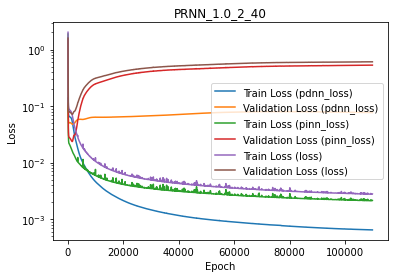

In [13]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.3 PDNN Error Analysis

In [14]:
np.random.seed(0)
reduction_method.initialize_testing_set(100)
test_mu = torch.tensor(reduction_method.testing_set)

In [15]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn
)

#################################### N = 17 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.003427258746149687	0.00015896145438063392	0.004070808058056092
mean	0.02449018476620693	0.010323919044846072	0.0287021422785237
max	0.19772547655293496	0.06569044854743859	0.23913557800891894


In [16]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn
)

#################################### N = 17 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.01270507982973676	0.011548473669214677	0.004070808058056092
mean	0.19302272424506983	0.19235473344133297	0.0287021422785237
max	1.8085207913193686	1.8484699792270016	0.23913557800891894


In [ ]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.)

pdnn_net.apply(init_weights)

pdnn_trainer.optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
pdnn_trainer.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(pdnn_trainer.optimizer, 0.99999)
pdnn_trainer.train()

_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn
)